In [21]:
import numpy as np
import pandas as pd


In [22]:
data=pd.read_csv('../Dataset/Bank_Personal_Loan_Modelling.csv')
data.head()


,ID_Customer,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [23]:
data.drop(columns='ID_Customer',inplace=True)

In [24]:
X=data.drop(columns='Personal Loan').astype('float32')
y=data['Personal Loan']

In [25]:
def train_test_spilt(X,y,test_size=0.2,random_state=None):
    if random_state:
        np.random.seed(random_state)
    indices=np.arange(X.shape[0])
    np.random.shuffle(indices)
    split_idx=int(X.shape[0]*(1-test_size))
    train_indices=indices[:split_idx]
    test_indices=indices[split_idx:]
    return X.iloc[train_indices],X.iloc[test_indices],y.iloc[train_indices],y.iloc[test_indices]

In [26]:
X_train,X_test,y_train,y_test=train_test_spilt(X,y,test_size=0.2,random_state=42)

In [27]:
def entropy(p):
    if(p==0) or (p==1):
        return 0
    else:
        return -p*np.log2(p)-(1-p)*np.log2(1-p)

In [28]:
def split_indices(X, index_feature, threshold):
    left_indices = []
    right_indices = []

    for i, x in enumerate(X):
        if x[index_feature] <= threshold:
            left_indices.append(i)
        else:
            right_indices.append(i)

    return left_indices, right_indices


In [29]:
def weighted_entropy(X,y,left_,right_):
    w_left=len(left_)/len(X)
    w_right=len(right_)/len(X)
    p_1_left=entropy(sum(y[left_])/len(left_))
    p_1_right=entropy(sum(y[right_])/len(right_))
    return (w_left*p_1_left)+(w_right*p_1_right)


In [30]:
def information_gain(X,y,left_,right_):
    p_root=entropy(sum(y)/len(y))
    w_entropy=weighted_entropy(X,y,left_,right_)
    return p_root-w_entropy

In [31]:
def best_spilt(X,y):
    n=X.shape[1]
    best_threshold=0
    best_feature=None
    best_gain=0
    best_set=None
    for i in range(n):
        threshold=np.unique(X[:,i])

        for th in threshold:
            left_indices,right_indices=split_indices(X,i,th)
            if len(left_indices)==0 or len(right_indices)==0:
                continue
            gain=information_gain(X,y,left_indices,right_indices)
            if gain>best_gain:
                best_gain=gain
                best_threshold=th
                best_feature=i
                best_set=(left_indices,right_indices)
    return best_feature,best_threshold,best_set



In [32]:
class Node:
    def __init__(self,feature=None,threshold=None,left=None,right=None,value=None):
        self.feature=feature
        self.threshold=threshold
        self.left=left
        self.right=right
        self.value=value    

In [33]:
def build_tree(X, y, depth=0, max_depth=5, min_samples=10):
    # stopping conditions
    if len(set(y)) == 1:
        return Node(value=y[0])

    if depth >= max_depth or len(y) < min_samples:
        return Node(value=int(np.round(np.mean(y))))

    feature, threshold, sets = best_spilt(X, y)

    if feature is None:
        return Node(value=int(np.round(np.mean(y))))

    left_idx, right_idx = sets

    left_child = build_tree(
        X[left_idx], y[left_idx],
        depth + 1, max_depth, min_samples
    )
    right_child = build_tree(
        X[right_idx], y[right_idx],
        depth + 1, max_depth, min_samples
    )

    return Node(feature, threshold, left_child, right_child)


In [34]:
def predict_one(x, node):
    if node.value is not None:
        return node.value
    if x[node.feature] <= node.threshold:
        return predict_one(x, node.left)
    return predict_one(x, node.right)


In [35]:
def predict(X, tree):
    return np.array([predict_one(x, tree) for x in X])


In [38]:
X_train_np = X_train.values
y_train_np = y_train.values
X_test_np = X_test.values

tree = build_tree(X_train_np, y_train_np, max_depth=15, min_samples=10)

y_train_pred = predict(X_train_np, tree)
y_test_pred = predict(X_test_np, tree)




In [39]:
train_acc = np.mean(y_train_pred == y_train)
test_acc = np.mean(y_test_pred == y_test)

print("Train Accuracy:", train_acc)
print("Test Accuracy :", test_acc)


Train Accuracy: 0.99625
Test Accuracy : 0.981


In [40]:
import matplotlib.pyplot as plt

def plot_tree(node, x=0.5, y=1.0, dx=0.2, dy=0.15, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.axis("off")

    # Leaf node
    if node.value is not None:
        ax.text(
            x, y,
            f"Predict: {node.value}",
            ha="center", va="center",
            bbox=dict(boxstyle="round", fc="lightgreen")
        )
        return

    # Decision node text
    text = f"X[{node.feature}] ≤ {node.threshold:.2f}"
    ax.text(
        x, y,
        text,
        ha="center", va="center",
        bbox=dict(boxstyle="round", fc="lightblue")
    )

    # Left child
    ax.plot([x, x - dx], [y - 0.02, y - dy], "k-")
    plot_tree(node.left, x - dx, y - dy, dx / 2, dy, ax)

    # Right child
    ax.plot([x, x + dx], [y - 0.02, y - dy], "k-")
    plot_tree(node.right, x + dx, y - dy, dx / 2, dy, ax)


<Figure size 1400x1000 with 0 Axes>

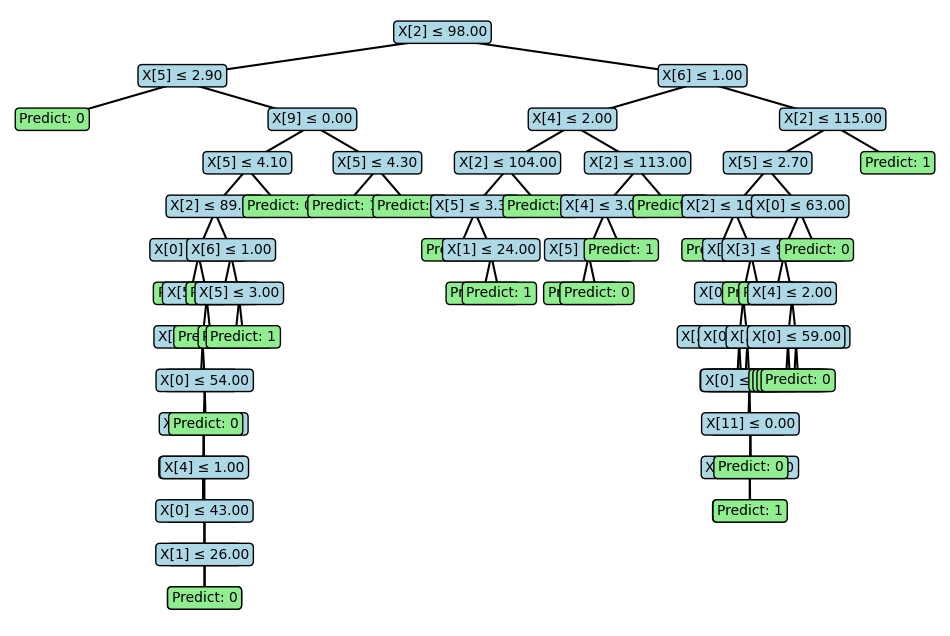

In [41]:
plt.figure(figsize=(14, 10))
plot_tree(tree)
plt.show()
